# Tropics Temperature Quantile Theory from Byrne 2021
This looks at applying the theory from Byrne 2021 but to an aquaplanet. This works by saying that the change in MSE on any day is equal to the mean change in MSE.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, L_v, c_p, g, R_v, epsilon
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy

2023-03-29 14:16:10,107 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [620]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 3.5
tau_lw_warm = 6
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=[np.inf], method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one dataset for summer for each $\kappa$, in a given latitude bin: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in January, February or March.

In [621]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 30
# lat_max = 60
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        # all days not summer
        # ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))

        # Only consider summer as has expected circulation
        ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
        ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
        # Combine hemispheres and average over longitude, time and latitude.
        # Note that April, May, June, October, November and December will not be included in this dataset
        ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        # Get rid of nan values corresponding to the winter hemisphere - half the values are nan
        ds_use = ds_use.sel(lon_lat_time = ds_use.lon_lat_time[np.invert(np.isnan(ds_use.temp[-1]))].to_numpy())

        ds_all += [ds_use]
        ds_all[i].load()
        pbar.update(1)

100%|██████████| 2/2 [00:18<00:00,  9.04s/it]


## MSE Percentile vs Temperature Percentile
Recreating Extended Data Figure 1 of Byrne 2021.

This shows the moist static energy percentiles (y-axis) corresponding to the average moist static energy of days exceeding the given temperature percentile.

The ocean plot shows good agreement with Byrne 2021, and this also shows that for land, in the warmer simulation, there is a decrease in $p_x$ as seen in Byrne 2021.

However, here we see an increase in $p_x$ for large $x$ over land, but in byrne 2021, we see a decrease.

In [622]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
def get_quant_ind(dataset, percentile):
    # Function to find indices in dataset corresponding to surface temperature above a given quantile
    quantile_thresh = dataset.temp[-1].quantile(percentile/100, dim='lon_lat_time', keep_attrs=True)
    quant_ind = np.where(dataset.temp[-1] > quantile_thresh)[0]
    return quant_ind

quant_plot = np.arange(100)     # first value must be 0 so temp_quant[0] is the mean value
n_quant = len(quant_plot)

# surface values corresponding to the average obove a given percentile in temperature
temp_quant = np.zeros((n_exp, n_quant))
sphum_quant = np.zeros((n_exp, n_quant))
z_quant = np.zeros((n_exp, n_quant))
mse_quant = np.zeros((n_exp, n_quant))


with tqdm(total=n_exp*n_quant, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j, quant in enumerate(quant_plot):
            use_ind = get_quant_ind(ds_all[i], quant)
            temp_quant[i, j] = np.mean(ds_all[i].temp[-1][use_ind])
            sphum_quant[i, j] = np.mean(ds_all[i].sphum[-1][use_ind])
            z_quant[i, j] = np.mean(ds_all[i].height[-1][use_ind])
            mse_quant[i, j] = np.mean(moist_static_energy(ds_all[i].temp[-1][use_ind],
                                                          ds_all[i].sphum[-1][use_ind],
                                                          ds_all[i].height[-1][use_ind]))
            pbar.update(1)

# temp_mean = {surf: np.asarray([temp_quant[surf][i][0] for i in range(n_exp)]) for surf in surfaces}

100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


In [623]:
# Get MSE percentile, p_x, corresponding to MSE averaged over all days exceeding x percentile in temperature
mse_quant_px = np.zeros((n_exp, n_quant))
with tqdm(total=n_exp*n_quant, position=0, leave=True) as pbar:
    for i in range(n_exp):
        mse_all = moist_static_energy(ds_all[i].temp[-1], ds_all[i].sphum[-1], ds_all[i].height[-1])
        for j, quant in enumerate(quant_plot):
            mse_quant_px[i, j] = percentileofscore(mse_all, mse_quant[i, j])
            pbar.update(1)

100%|██████████| 200/200 [00:00<00:00, 1080.10it/s]


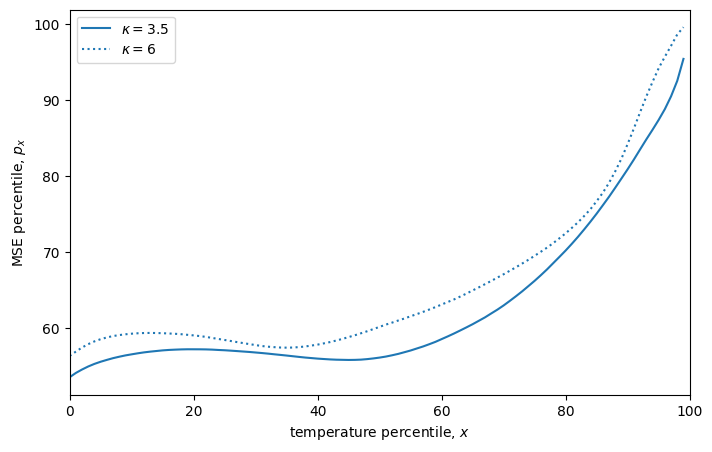

In [624]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyles = ['-', ':']     # different for each kappa
fig, ax = plt.subplots(1,1, figsize=(8, 5), sharex=True)
for i in range(n_exp):
    ax.plot(quant_plot, mse_quant_px[i], color=default_colors[0], linestyle=linestyles[i],
            label=f'$\kappa={tau_lw[i]}$')
ax.legend()
ax.set_xlabel('temperature percentile, $x$')
ax.set_ylabel('MSE percentile, $p_x$')
ax.set_xlim(0,100);

## Ocean to Ocean Mean changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3, applied to an aquaplanet.

The scaling $\lambda(p) = \frac{\delta h(p)}{\delta \overline{h}}$, is very close to 1 for all percentiles, implying that the theory may be appropriate.

In [625]:
# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_quant))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = np.zeros((n_exp, n_quant))
# mse as function of mse quantile not temp quantile
mse_quant2 = np.zeros((n_exp, n_quant))

for i in range(n_exp):
        temp_quant2[i] = ds_all[i].temp[-1].quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
        sphum_quant2[i] = ds_all[i].sphum[-1].quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
        mse = moist_static_energy(ds_all[i].temp[-1], ds_all[i].sphum[-1], ds_all[i].height[-1])
        mse_quant2[i] = mse.quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)

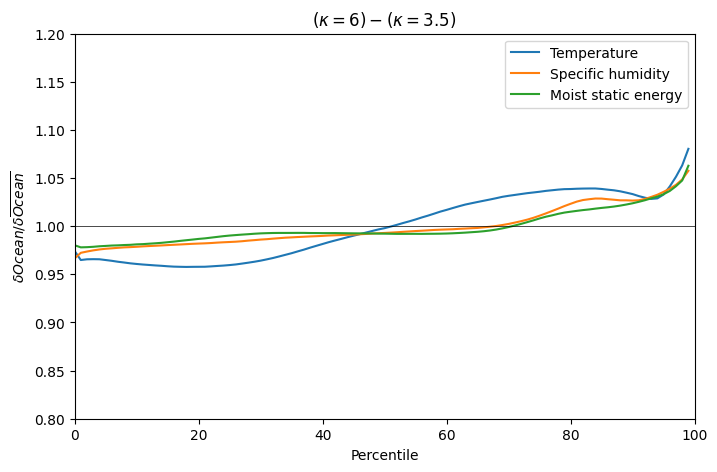

In [626]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
labels = ['Temperature', 'Specific humidity', 'Moist static energy']
# Divide by the difference in the mean not by the difference in the median because from the above plot, the percentile p_x=50 for
# MSE does not have a corresponding temperature percentile, x.
delta_var_mean = [var[1][0] - var[0][0] for var in [temp_quant, sphum_quant, mse_quant]]
for i, var in enumerate([temp_quant2, sphum_quant2, mse_quant2]):
    ax.plot(quant_plot, (var[1]-var[0])/delta_var_mean[i], label=labels[i])
ax.hlines(1,0,100, color='k', linewidth=0.5)
ax.legend()
ax.set_xlabel('Percentile')
ax.set_ylabel('$\delta Ocean/\delta \overline{Ocean}$')
ax.set_ylim(0.8,1.2)
ax.set_xlim(0, 100)
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$');

## Theory for $\delta T^x$

### Form of MSE equation to start theory
The starting equation used in the paper is equation 9. Applied to an aquaplanet, this becomes: $\delta h^x = \delta \overline{h} + \Delta h$.

The plot below shows that this differs from the exact theory in red, $\delta h^x = \lambda(p^x) \delta \overline{h} + \Delta h$ by at most 2%, again implying that it may be a suitable starting point for a theory for $\delta T^x$.

In [627]:
# Ocean constants required - these are for the percentile px which corresponds to the average above the x percentile in temperature
# We assume the change in the p xth percentile of ocean moist static energy can be written to good approximation as
# a function of the individual changes in the pxth percentiles of temperature and specific humidity - from Methods page of paper
# p_x[i] is the percentile of MSE corresponding to average above the percentile quant_all[i] of temperature in reference climate.
p_x = np.round(mse_quant_px[0]).astype(int)

# Actual ratio between MSE changes on land vs ocean for percentile p_x - assume this to be 1 in paper
lambda_px = (mse_quant2[1][p_x]-mse_quant2[0][p_x])/(mse_quant[1]-mse_quant[0])[0]

# Get actual delta_h from change in quantile formula
mse_all = moist_static_energy(ds_all[1].temp[-1], ds_all[1].sphum[-1], ds_all[1].height[-1])
delta_h = np.quantile(mse_all, mse_quant_px[1]/100) - np.quantile(mse_all, mse_quant_px[0]/100)

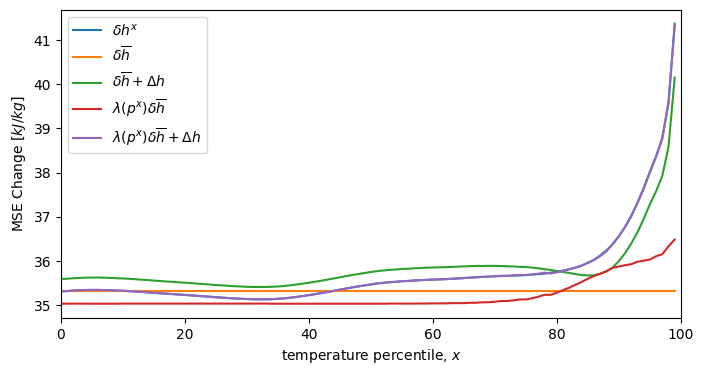

In [628]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.plot(quant_plot, mse_quant[1]-mse_quant[0], label='$\delta h^x$')
ax.plot(quant_plot, (mse_quant[1]-mse_quant[0])[0] * np.ones(n_quant), label='$\delta \overline{h}$')
ax.plot(quant_plot, (mse_quant[1]-mse_quant[0])[0] + delta_h, label='$\delta \overline{h} + \Delta h$')
ax.plot(quant_plot, lambda_px * (mse_quant[1]-mse_quant[0])[0],
        label = '$\lambda(p^x) \delta \overline{h}$')
ax.plot(quant_plot, lambda_px * (mse_quant[1]-mse_quant[0])[0] + delta_h,
        label = '$\lambda(p^x) \delta \overline{h} + \Delta h$')
ax.set_ylabel('MSE Change [$kJ/kg$]')
ax.set_xlabel('temperature percentile, $x$')
ax.legend()
ax.set_xlim(0,100);

### Theory for $\Delta h$
The above plot uses the exact form of $\Delta h = h^{\kappa_{warm}}(p^x + \delta p^x) - h^{\kappa_{warm}}(p^x)$. In Byrne 2021, they use equation 24, $\Delta h = L_v(\delta r_L^x q^x_{L,sat} - \delta \bar{r_L}  \overline{q_{L,sat}})$ as an approximation to this.

In the context of an aquaplanet, this theory becomes: $\Delta h = L_v(\delta r^x q^x_{sat} - \delta \bar{r}  \overline{q_{sat}})$ and we see below that this does a pretty decent job at matching the simulated $\Delta h$.

Note that the below figure is a recreation of Extended Data Figure 3. In the top plot, the $\delta p^x$ theoretical value comes from equation 23 in the paper: $\delta p^x \approx \frac{L_v}{\beta_1}(\delta r^x q^x_{sat} - \delta \bar{r}  \overline{q_{sat}})$.

In [629]:
# Variables required for Delta T theory
p_surface = float(ds_all[0].pfull[-1]) * 100  # pressure where surface temperature is computed - same for all ds

def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def clausius_clapeyron_factor2(temp):
    # Rather than saying d_sphum_sat_d_temp = alpha \times sphum_sat,
    # here I explicitly compute alpha from the formula for saturation_vapor_pressure using in isca_tools
    lambda_const = 4302.645 / (temp - 29.65)**2
    return lambda_const * p_surface / epsilon * sphum_sat(temp, p_surface) / saturation_vapor_pressure(temp)

# Land constants required - all averaged over the x percentile temperature day
# i.e. there are 100 values for each of these constants
q_x_sat = sphum_sat(temp_quant[0], p_surface)
q_mean_sat = q_x_sat[0]
q_x = sphum_quant[0]
r_x = q_x / q_x_sat
delta_r_x = sphum_quant[1]/sphum_sat(temp_quant[1], p_surface) - r_x
r_mean = r_x[0]
delta_r_mean = delta_r_x[0]
alpha = clausius_clapeyron_factor2(temp_quant[0])
alpha_mean = alpha[0]

delta_temp_quant = temp_quant[1] - temp_quant[0]
delta_temp_mean = delta_temp_quant[0]
delta_mse_mean = (mse_quant[1] - mse_quant[0])[0]

In [630]:
# Variables required for Delta h theory
p_mean = np.zeros(n_exp)
h_mean = np.zeros(n_exp)
beta1 = np.zeros(n_exp)
beta2 = np.zeros((n_exp, n_quant))

for i in range(n_exp):
    mse_all = moist_static_energy(ds_all[i].temp[-1], ds_all[i].sphum[-1], ds_all[i].height[-1])
    h_mean[i] = float(np.mean(mse_all))
    p_mean[i] = percentileofscore(mse_all.to_numpy(), h_mean[i])
    beta1[i] = np.gradient(mse_quant2[i], quant_plot)[int(np.round(p_mean[i]))]
    beta2[i] = np.gradient(mse_quant2[i], quant_plot)[p_x]

# p_mean = int(np.round(percentileofscore(mse_all, float(np.mean(mse_all)))))
# beta1 = np.gradient(mse_quant2[0], quant_plot)[p_mean]
delta_h_theory = L_v/1000 * (delta_r_x * q_x_sat - delta_r_mean * q_mean_sat)
delta_h_theory2 = L_v/1000 * (delta_r_x * q_x_sat + q_x_sat * alpha * delta_r_x * delta_temp_quant -
                              delta_r_mean * q_mean_sat - (q_x_sat * alpha * delta_r_x * delta_temp_quant)[0])

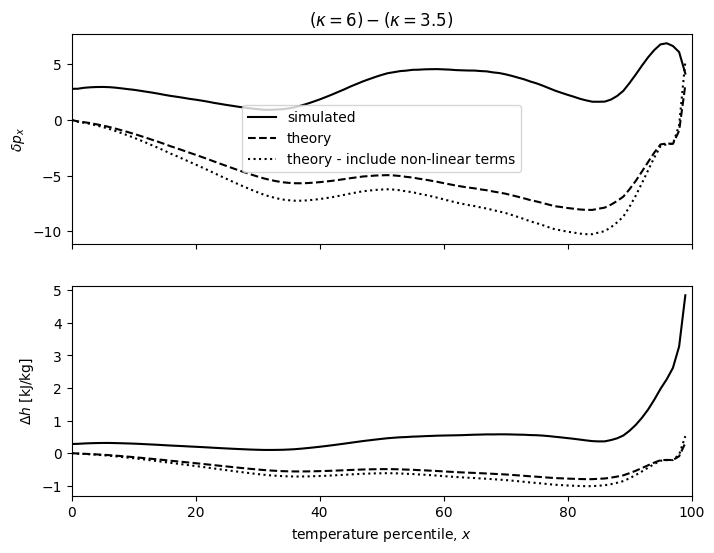

In [631]:
fig_delta_h, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax[0].plot(quant_plot, mse_quant_px[1] - mse_quant_px[0], color='k', label='simulated')
ax[0].plot(quant_plot, delta_h_theory / beta1[0], color='k', linestyle='--', label='theory')
ax[0].plot(quant_plot, delta_h_theory2 / beta1[0], color='k', linestyle=':', label='theory - include non-linear terms')
ax[1].plot(quant_plot, delta_h, color='k', label='simulated')
ax[1].plot(quant_plot, delta_h_theory, color='k', linestyle='--', label='theory')
ax[1].plot(quant_plot, delta_h_theory2, color='k', linestyle=':', label='theory - include non-linear terms')
ax[0].legend()
ax[0].set_ylabel('$\delta p_x$')
ax[1].set_ylabel('$\Delta h$ [kJ/kg]')
ax[1].set_xlabel('temperature percentile, $x$')
ax[0].set_xlim([0,100])
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$');

### Taylor Series Decomposition of $\delta h^x$


In [632]:
term0 = c_p * delta_temp_quant
term1 = L_v * alpha * q_x * delta_temp_quant
term2 = L_v * q_x_sat * delta_r_x
term3 = L_v * q_x_sat * alpha * delta_r_x * delta_temp_quant
term4 = 0.5 * L_v * q_x * alpha * (alpha - 2/temp_quant[0])*delta_temp_quant**2
mse_taylor_terms = np.asarray([term0, term1, term2, term3, term4])
mse_mean_taylor_terms = mse_taylor_terms[:, 0]

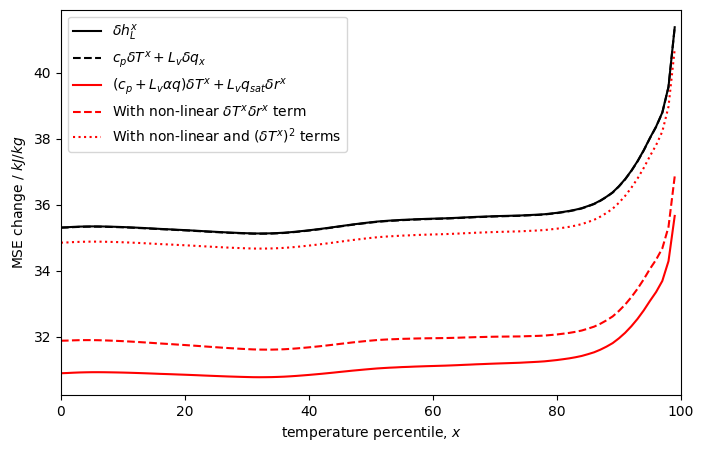

In [633]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(quant_plot, mse_quant[1]-mse_quant[0], color='k', label='$\delta h^x_L$')
ax.plot(quant_plot, (c_p * (temp_quant[1]-temp_quant[0]) + L_v * (sphum_quant[1] - sphum_quant[0]))/1000, color='k',
        label='$c_p \delta T^x + L_v \delta q_x$', linestyle='--')
ax.plot(quant_plot, np.sum(mse_taylor_terms[:3], axis=0)/1000, color='r',
        label='$(c_p+L_v\\alpha q) \delta T^x + L_v q_{sat} \delta r^x$')
ax.plot(quant_plot, np.sum(mse_taylor_terms[:4], axis=0)/1000, color='r', linestyle='--',
        label='With non-linear $\delta T^x \delta r^x$ term')
ax.plot(quant_plot, np.sum(mse_taylor_terms, axis=0)/1000, color='r', linestyle=':',
        label='With non-linear and $(\delta T^x)^2$ terms')
ax.legend()
ax.set_xlabel('temperature percentile, $x$')
ax.set_ylabel('MSE change / $kJ/kg$')
ax.set_xlim(0,100);

## Hierarchy of Theories for $\delta T^x$

The theory for $\delta T^x$ is based on considering the change in MSE of days exceeding the $x$th percentile in temperature, $\delta h^x = h^{\kappa_{warm}}(p^x_{\kappa_{warm}}) - h^{\kappa_{ref}}(p^x_{\kappa_{ref}})$ where $p^x_{\kappa_{ref}}$ is the percentile of MSE corresponding to the MSE averaged over all days exceeding percentile $x$ in temperature in the reference simulation. Equally, $p^x +\delta p^x = p^x_{\kappa_{warm}}$ is the percentile of MSE corresponding to the MSE averaged over all days exceeding percentile $x$ in temperature in the warmer simulation (the MSE distribution changes with warming so the percentile of MSE corresponding to a given temperature percentile will also change).

So we have $\delta h^x = h^{\kappa_{warm}}(p^x + \delta p^x) - h^{\kappa_{ref}}(p^x)$.
Then subbing in for $\delta h(p^x) = \lambda(p^x) \delta \overline{h} =  h^{\kappa_{warm}}(p^x) - h^{\kappa_{ref}}(p^x)$, we get:
$\delta h^x = h^{\kappa_{warm}}(p^x + \delta p^x) - h^{\kappa_{warm}}(p^x) + \lambda(p^x) \delta \overline{h}$
Then we can use the definition of $\Delta h = h^{\kappa_{warm}}(p^x + \delta p^x) - h^{\kappa_{warm}}(p^x)$ to give:
$\delta h^x = \lambda(p^x) \delta \overline{h} + \Delta h$

To turn this into a theory for $\delta T^x$ we need to expand $\delta h^x$ in a taylor series of $\delta T^x$ and $\delta r^x$. From the MSE change plot, we see that we need to go up to the $(\delta T^x)^2$ term in the taylor series to best match the actual MSE change (red dot/dashed line matches black line). Doing this taylor expansion, we get the equation:

$$\frac{L_v}{2\Gamma}\alpha q^x (\alpha^x - \frac{2}{T^x})(\delta T^x)^2 + (1 + \epsilon \delta r^x)\delta T^x = - \frac{\epsilon}{\alpha^x}\delta r^x + \frac{1}{\Gamma}(\lambda(p^x) \delta \overline{h} + \Delta h)$$

Where, $\Gamma = c_p + L_v \alpha^x q^x$ and $\epsilon = \frac{L_v \alpha^x q^x_{sat}}{\Gamma}$ ($\epsilon$ is used in the paper).

Theory 1 in the plot below shows the solution to this equation (using $\lambda(p^x)$, $\delta \overline{h}$ and $\Delta h$ computed directly from the output of the simulation), and it is clear that it matches the simulated value almost exactly.

The other theories in the left plot offer various simplifications to this:
* Theory 2 - Assumes $\lambda(p^x)=1$
* Theory 4 - Uses theory of $\Delta h$ given by equation 24 in the paper.

The theories on the right plot make no assumptions about $\lambda(p^x)$ or $\Delta h$ but use different number of terms in the taylor expansion of $\delta h^x$ and $\delta \overline{h}$:
* Theory 5 - $\delta h^x$ taylor expansion includes non-linear $\delta T^x \delta r^x$ and squared $(\delta T^x)^2$ terms.
$\delta \overline{h}$ taylor expansion includes non-linear $\delta \overline{T} \delta \overline{r}$ and squared $\delta \overline{T}^2$ terms.
* Theory 6 - $\delta h^x$ taylor expansion includes non-linear $\delta T^x \delta r^x$ term.
$\delta \overline{h}$ taylor expansion includes non-linear $\delta \overline{T} \delta \overline{r}$ term.
* Theory 7 - $\delta h^x$ taylor expansion includes non-linear $\delta T^x \delta r^x$ term.
$\delta \overline{h}$ taylor expansion includes just linear terms.
* Theory 8 - $\delta h^x$ taylor expansion includes just linear terms.
$\delta \overline{h}$ taylor expansion includes just linear terms.

Theories 9 and 10 use the approximations of theory 2 and 4, but also use a taylor expansion.
* Theory 9 - $\delta h^x$ taylor expansion includes just linear terms.
$\delta \overline{h}$ taylor expansion includes just linear terms.
Assumes $\lambda(p^x)=1$
Uses theory of $\Delta h$ given by equation 24 in the paper.
* Theory 10 - $\delta h^x$ taylor expansion includes non-linear $\delta T^x \delta r^x$ term.
$\delta \overline{h}$ taylor expansion includes non-linear $\delta \overline{T} \delta \overline{r}$ term.
Assumes $\lambda(p^x)=1$
Uses theory of $\Delta h$ given by equation 24 in the paper.
* Theory 14 - Same as Theory 10 but uses simulated $\lambda(p^x)$, i.e. does not assume it is 1.

Theories 11, 12 and 13 all assume that $\Delta h = 0$.
* Theory 11 - Assumes $\Delta h = 0$
* Theory 12 - Assumes $\Delta h = 0$ and $\lambda(p^x)=1$.
* Theory 13 - Assumes $\Delta h = 0$ and $\lambda(p^x)=1$.
$\delta h^x$ taylor expansion includes non-linear $\delta T^x \delta r^x$ term.
$\delta \overline{h}$ taylor expansion includes non-linear $\delta \overline{T} \delta \overline{r}$ term.

Note that Theory 1 and Theory 5 differ below, only because the assumption that $\delta \overline{h} = c_p \delta \overline{T} + L_v \delta \overline{q}$ is not exactly satisfied, as is shown by the difference between the black solid and black dotted line in the ocean MSE change plot.


In [634]:
e_const = L_v * alpha * q_x_sat / (c_p + L_v * alpha * q_x)
# Theory 1 - No assumptions
denom = c_p + L_v * alpha * q_x
coef_a = 0.5 * L_v * alpha * q_x * (alpha - 2/temp_quant[0]) / denom
coef_b = 1 + e_const * delta_r_x
coef_c = e_const/alpha * delta_r_x - (
        lambda_px * delta_mse_mean*1000 + 1000*delta_h)/denom
temp_diff_land_theory_1 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

# Theory 2 - Assume equal changes in percentile p of MSE over ocean and land
coef_c = e_const/alpha * delta_r_x - (delta_mse_mean*1000 + 1000*delta_h)/denom
temp_diff_land_theory_2 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

# Theory 4 - With theory in paper for delta_h
coef_c = e_const/alpha * delta_r_x - (
        lambda_px * delta_mse_mean * 1000 + 1000*delta_h_theory)/denom
temp_diff_land_theory_4 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

# Theory 5 - Taylor expansion including non-linear and squared terms for mean MSE change
coef_c = e_const/alpha * delta_r_x - (
        lambda_px * np.sum(mse_mean_taylor_terms, axis=0) + 1000 * delta_h)/denom
temp_diff_land_theory_5 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

# Theory 6 - Neglect squared term in taylor expansion of x and mean but keep non linear for both
coef_c = e_const/alpha * delta_r_x - (
        lambda_px * np.sum(mse_mean_taylor_terms[:4], axis=0) + 1000*delta_h)/denom
temp_diff_land_theory_6 = -coef_c/coef_b

# Theory 7 - Neglect squared term and non-linear term in mean, neglect squared term in x.
coef_c = e_const/alpha * delta_r_x - (
        lambda_px * np.sum(mse_mean_taylor_terms[:3], axis=0) + 1000*delta_h)/denom
temp_diff_land_theory_7 = -coef_c/coef_b

# Theory 8 - Neglect squared term and non-linear term in mean and x.
coef_b = 1
temp_diff_land_theory_8 = -coef_c/coef_b

# Theory 9 - neglect squared term and non-linear term in mean and x. Also, assume lambda=1 and use theory for delta_h including
# just linear terms - gives same value as below which includes non-linear stuff.
coef_b = 1
coef_c = e_const/alpha * delta_r_x - (
         np.sum(mse_mean_taylor_terms[:3], axis=0) + 1000*delta_h_theory)/denom
temp_diff_land_theory_9 = -coef_c/coef_b
# # Theory 9 - neglect squared term but keep non-linear term in mean and x. Also, assume lambda=1 and use theory for delta_h
# # including non-linear terms - gives same value as above just linear case.
# coef_b = 1 + e_const * delta_r_x
# coef_c = e_const/alpha * delta_r_x - (
#          np.sum(mse_mean_taylor_terms[:4], axis=0) + 1000*delta_h_theory2)/denom
# temp_diff_land_theory_9 = -coef_c/coef_b

# Theory 10 - Neglect squared term in taylor expansion of x and mean but keep non linear for both.
# Also use theory for delta_h including just linear terms
coef_b = 1 + e_const * delta_r_x
coef_c = e_const/alpha * delta_r_x - (np.sum(mse_mean_taylor_terms[:4], axis=0) + 1000*delta_h_theory)/denom
temp_diff_land_theory_10 = -coef_c/coef_b

# Theory 14 - Same as theory 10 but use simulated lambda rather than assuming it is 1.
temp_diff_land_theory_14 = lambda_px * temp_diff_land_theory_10

# Theory 11 - delta_h = 0
coef_c = e_const/alpha * delta_r_x - (
        lambda_px * delta_mse_mean * 1000)/denom
temp_diff_land_theory_11 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

# Theory 12 - delta_h = 0 and lambda=1
coef_c = e_const/alpha * delta_r_x - (delta_mse_mean * 1000)/denom
temp_diff_land_theory_12 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

# Theory 13 - Neglect squared term in taylor expansion of x and mean but keep non linear for both.
# Also assume delta_h = 0 and lambda=1 i.e. theory 10 without delta_h
coef_c = e_const/alpha * delta_r_x - (np.sum(mse_mean_taylor_terms[:4], axis=0))/denom
temp_diff_land_theory_13 = -coef_c/coef_b

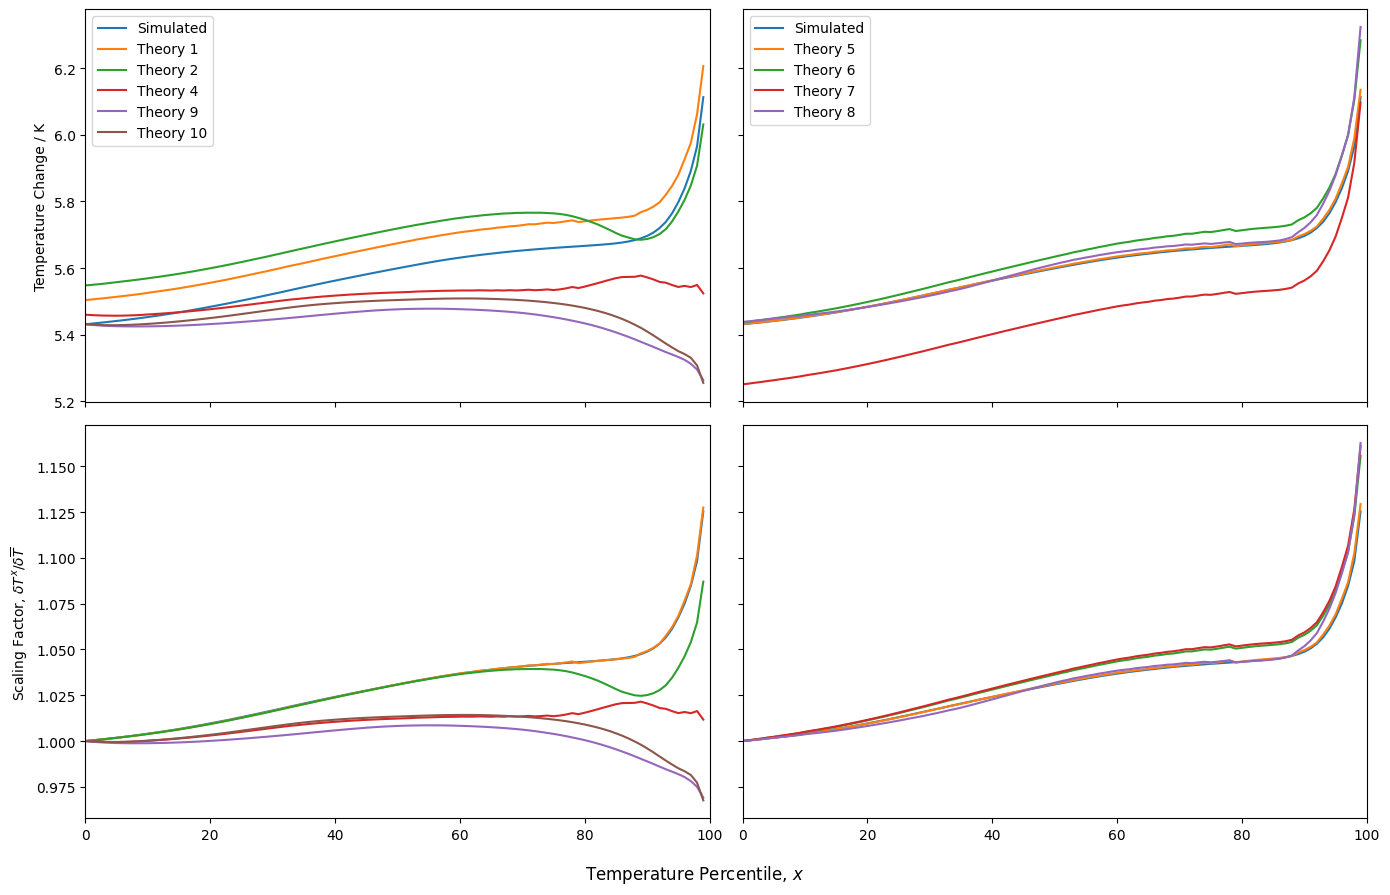

In [635]:
fig, ax = plt.subplots(2,2, figsize=(14, 9), sharex=True, sharey='row')
ax = ax.flatten()
ax[0].plot(quant_plot, delta_temp_quant, label='Simulated')
ax[0].plot(quant_plot, temp_diff_land_theory_1, label='Theory 1')
ax[0].plot(quant_plot, temp_diff_land_theory_2, label='Theory 2')
ax[0].plot(quant_plot, temp_diff_land_theory_4, label='Theory 4')
ax[0].plot(quant_plot, temp_diff_land_theory_9, label='Theory 9')
ax[0].plot(quant_plot, temp_diff_land_theory_10, label='Theory 10')

ax[2].plot(quant_plot, delta_temp_quant/delta_temp_quant[0], label='Simulated')
ax[2].plot(quant_plot, temp_diff_land_theory_1/temp_diff_land_theory_1[0], label='Theory 1')
ax[2].plot(quant_plot, temp_diff_land_theory_2/temp_diff_land_theory_2[0], label='Theory 2')
ax[2].plot(quant_plot, temp_diff_land_theory_4/temp_diff_land_theory_4[0], label='Theory 4')
ax[2].plot(quant_plot, temp_diff_land_theory_9/temp_diff_land_theory_9[0], label='Theory 9')
ax[2].plot(quant_plot, temp_diff_land_theory_10/temp_diff_land_theory_10[0], label='Theory 10')

ax[1].plot(quant_plot, delta_temp_quant, label='Simulated')
ax[1].plot(quant_plot, temp_diff_land_theory_5, label='Theory 5')
ax[1].plot(quant_plot, temp_diff_land_theory_6, label='Theory 6')
ax[1].plot(quant_plot, temp_diff_land_theory_7, label='Theory 7')
ax[1].plot(quant_plot, temp_diff_land_theory_8, label='Theory 8')

ax[3].plot(quant_plot, delta_temp_quant/delta_temp_quant[0], label='Simulated')
ax[3].plot(quant_plot, temp_diff_land_theory_5/temp_diff_land_theory_5[0], label='Theory 5')
ax[3].plot(quant_plot, temp_diff_land_theory_6/temp_diff_land_theory_6[0], label='Theory 6')
ax[3].plot(quant_plot, temp_diff_land_theory_7/temp_diff_land_theory_7[0], label='Theory 7')
ax[3].plot(quant_plot, temp_diff_land_theory_8/temp_diff_land_theory_8[0], label='Theory 8')

ax[0].legend()
ax[1].legend()
ax[0].set_xlim([0,100])
ax[0].set_ylabel('Temperature Change / K')
ax[2].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
fig.supxlabel('Temperature Percentile, $x$')
plt.tight_layout();

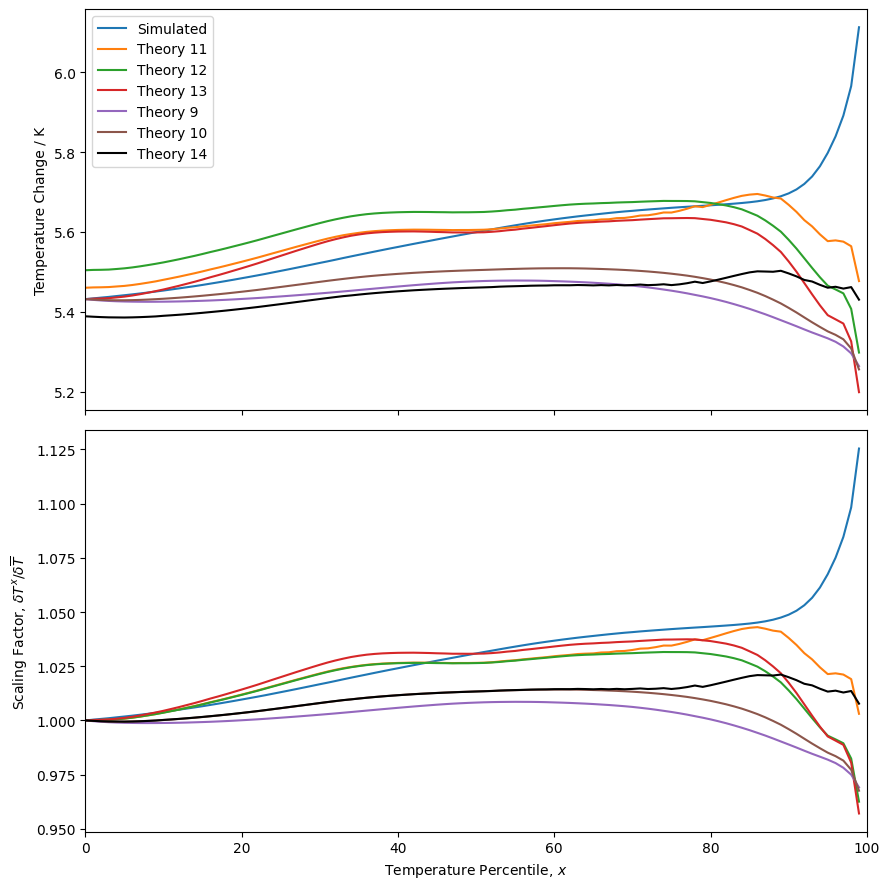

In [636]:
fig, ax = plt.subplots(2,1, figsize=(9, 9), sharex=True, sharey='row')
ax[0].plot(quant_plot, delta_temp_quant, label='Simulated')
ax[0].plot(quant_plot, temp_diff_land_theory_11, label='Theory 11')
ax[0].plot(quant_plot, temp_diff_land_theory_12, label='Theory 12')
ax[0].plot(quant_plot, temp_diff_land_theory_13, label='Theory 13')
ax[0].plot(quant_plot, temp_diff_land_theory_9, label='Theory 9')
ax[0].plot(quant_plot, temp_diff_land_theory_10, label='Theory 10')
ax[0].plot(quant_plot, temp_diff_land_theory_14, label='Theory 14', color='k')

ax[1].plot(quant_plot, delta_temp_quant/delta_temp_quant[0], label='Simulated')
ax[1].plot(quant_plot, temp_diff_land_theory_11/temp_diff_land_theory_11[0], label='Theory 11')
ax[1].plot(quant_plot, temp_diff_land_theory_12/temp_diff_land_theory_12[0], label='Theory 12')
ax[1].plot(quant_plot, temp_diff_land_theory_13/temp_diff_land_theory_13[0], label='Theory 13')
ax[1].plot(quant_plot, temp_diff_land_theory_9/temp_diff_land_theory_9[0], label='Theory 9')
ax[1].plot(quant_plot, temp_diff_land_theory_10/temp_diff_land_theory_10[0], label='Theory 10')
ax[1].plot(quant_plot, temp_diff_land_theory_14/temp_diff_land_theory_14[0], label='Theory 14', color='k')
ax[0].legend()

ax[0].set_xlim([0,100])
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
plt.tight_layout();

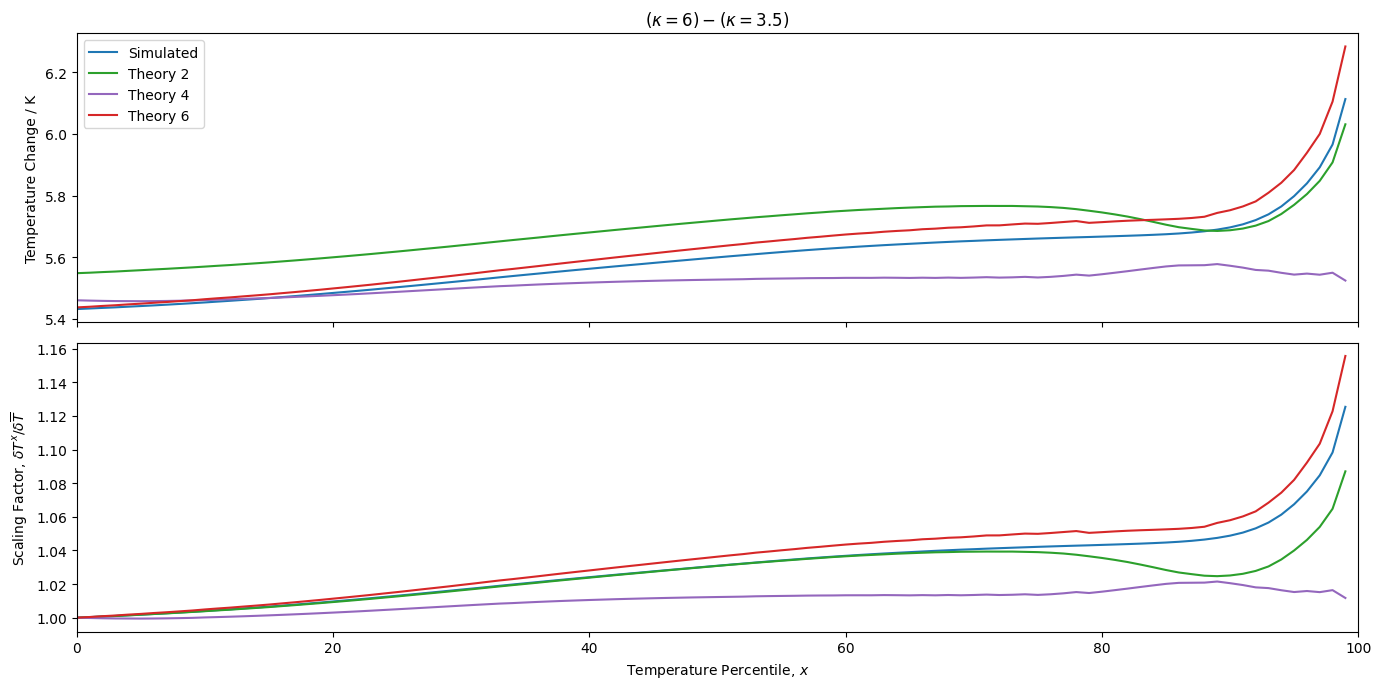

In [637]:
# Just show each of 3 assumptions independently.
# Theory 2 shows effect of neglecting lambda
# Theory 4 shows effect of using theory for delta h
# Theory 6 shows effect of neglecting squared terms in taylor expansion of h_L and h_mean
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(2,1, figsize=(14, 7), sharex=True, sharey='row')
ax[0].plot(quant_plot, delta_temp_quant, label='Simulated')
ax[0].plot(quant_plot, temp_diff_land_theory_2, label='Theory 2', color=default_colors[2])
ax[0].plot(quant_plot, temp_diff_land_theory_4, label='Theory 4', color=default_colors[4])
ax[0].plot(quant_plot, temp_diff_land_theory_6, label='Theory 6', color=default_colors[3])
ax[1].plot(quant_plot, delta_temp_quant/delta_temp_quant[0], label='Simulated')
ax[1].plot(quant_plot, temp_diff_land_theory_2/temp_diff_land_theory_2[0], label='Theory 2', color=default_colors[2])
ax[1].plot(quant_plot, temp_diff_land_theory_4/temp_diff_land_theory_4[0], label='Theory 4', color=default_colors[4])
ax[1].plot(quant_plot, temp_diff_land_theory_6/temp_diff_land_theory_6[0], label='Theory 6', color=default_colors[3])
ax[0].legend()
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
ax[0].set_xlim([0,100])
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
plt.tight_layout();

### Components of temperature response
From the above plot, we see that Theory 9 is probably the simplest theory that can predict $\delta T^x$ well.

The theory for this (only keeping linear terms and setting $\lambda(p^x)=1$) is given by:
$$\delta T^x = - \frac{L_v q^x_{sat}}{\Gamma}\delta r^x + \frac{1}{\Gamma}(\delta \overline{h} + \Delta h)$$
Where $\delta \overline{h} = (c_p + L_v \bar{\alpha}\bar{q}) \delta \overline{T} + L_v \overline{q_{sat}} \delta \overline{r}$ and $\Delta h = L_v(\delta r^x q^x_{sat} - \delta \bar{r}  \overline{q_{sat}})$.

Putting this altogether, the relative humidity terms cancel and we get:
$$\delta T^x = \frac{c_p + L_v \bar{\alpha}\bar{q}}{\Gamma}\delta \overline{T} =
\frac{c_p + L_v \bar{\alpha}\bar{q}}{c_p + L_v \alpha^x q^x}\delta \overline{T}$$

The final result is the same if we include the non-linear terms $\delta T^x \delta r^x$ in both the taylor expansion of $\delta h^x$ and $\delta \overline{h}$ i.e. Theory 6, as well as in $\Delta h$ i.e. the dotted line rather than the dashed line in the $\Delta h$ plot. It probably makes more sense to think about it this way, as it is more accurate at each stage.

Theory 10 is what we get if include the non-linear terms $\delta T^x \delta r^x$ in both the taylor expansion of $\delta h^x$ and $\delta \overline{h}$ i.e. Theory 6, but neglect them in $\Delta h$ i.e. the dashed line rather than the dotted line in the $\Delta h$ plot. As a result, some relative humidity terms don't cancel, and we get:

$$(1 + \epsilon \delta r^x)\delta T^x = - \frac{L_v q^x_{sat}}{\Gamma}\delta r^x + \frac{1}{\Gamma}(\delta \overline{h} + \Delta h)$$
Where $\delta \overline{h} = (c_p + L_v \bar{\alpha}\bar{q} + L_v\bar{\alpha}\overline{q_{sat}}\delta \overline{r}) \delta \overline{T} + L_v \overline{q_{sat}} \delta \overline{r}$ and $\Delta h = L_v(\delta r^x q^x_{sat} - \delta \bar{r}  \overline{q_{sat}})$.

Putting this altogether, some relative humidity terms cancel, and we get:
$$\delta T^x = \frac{1}{1 + \epsilon \delta r^x}\frac{c_p + L_v \bar{\alpha}(\bar{q} + \overline{q_{sat}}\delta \overline{r})}{c_p + L_v \alpha^x q^x}\delta \overline{T}$$

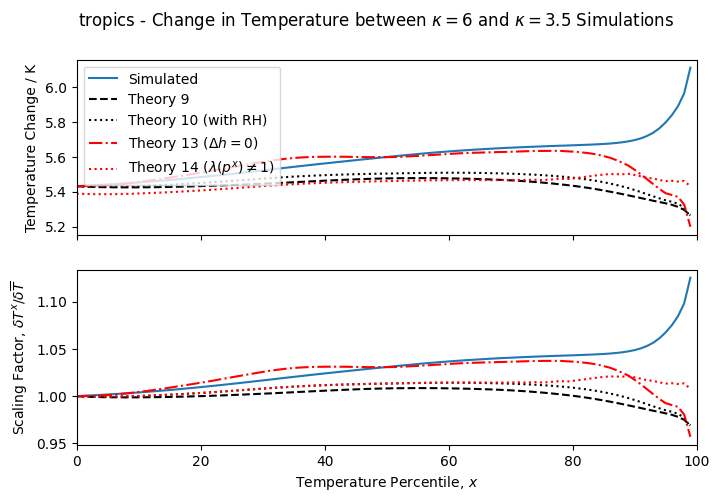

In [638]:
fig_temp, ax = plt.subplots(2,1, figsize=(8, 5), sharex=True)
ax[0].plot(quant_plot, delta_temp_quant, label='Simulated', color=default_colors[0])
ax[1].plot(quant_plot, delta_temp_quant/delta_temp_quant[0], color=default_colors[0])
ax[0].plot(quant_plot, temp_diff_land_theory_9, label='Theory 9', linestyle='--', color='k')
ax[0].plot(quant_plot, temp_diff_land_theory_10, label='Theory 10 (with RH)', linestyle=':', color='k')
ax[0].plot(quant_plot, temp_diff_land_theory_13, label='Theory 13 ($\Delta h = 0$)', linestyle='-.', color='r')
ax[0].plot(quant_plot, temp_diff_land_theory_14, label='Theory 14 ($\lambda(p^x) \\neq 1$)', linestyle=':', color='r')
ax[1].plot(quant_plot, temp_diff_land_theory_9/temp_diff_land_theory_9[0], label=f'Theory 9', linestyle='--', color='k')
ax[1].plot(quant_plot, temp_diff_land_theory_10/temp_diff_land_theory_10[0], label='Theory 10 (with RH)', linestyle=':', color='k')
ax[1].plot(quant_plot, temp_diff_land_theory_13/temp_diff_land_theory_13[0], label='Theory 13 ($\Delta h = 0$)', linestyle='-.', color='r')
ax[1].plot(quant_plot, temp_diff_land_theory_14/temp_diff_land_theory_14[0], label='Theory 14 ($\lambda(p^x) \\neq 1$)',
           linestyle=':', color='r')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].legend()
ax[0].set_xlim(0,100)
# ax[0].set_ylim(4, 8.5)
# ax[1].set_ylim(0.9, 1.25)
plt.suptitle(f"{region} - Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");

## In Depth Look at $\Delta h$

[0.09885452 0.10251511]
[53.50359623 56.3062996 ]


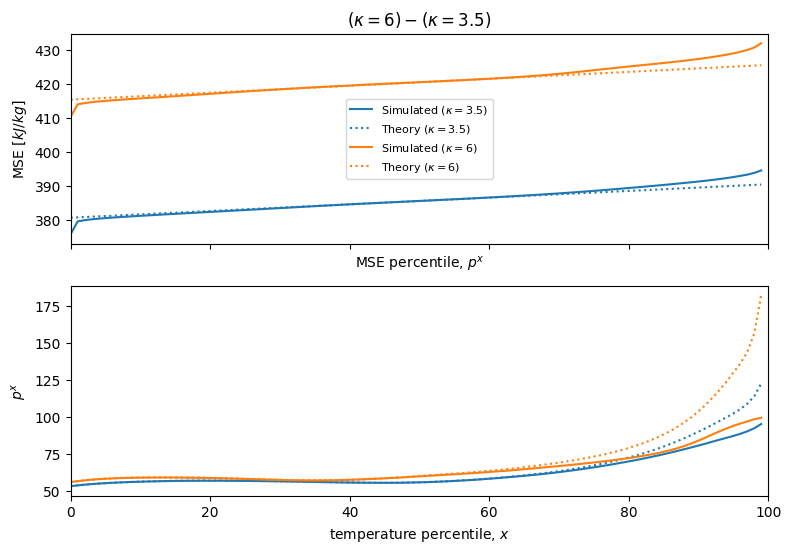

In [639]:
# Equation 19 and 22 plot
fig, ax = plt.subplots(2,1, figsize=(9, 6), sharex=True)
for i in range(n_exp):
    # Equation 19 plot
    ax[0].plot(quant_plot, mse_quant2[i], color=default_colors[i], label=f'Simulated ($\kappa={tau_lw[i]}$)')
    ax[0].plot(quant_plot, beta1[i]*(quant_plot-p_mean[i])+h_mean[i], color=default_colors[i], linestyle=':',
               label=f'Theory ($\kappa={tau_lw[i]}$)')

    ax[1].plot(quant_plot, mse_quant_px[i], color=default_colors[i])
    ax[1].plot(quant_plot, (mse_quant[i] - h_mean[i])/beta1[i] + p_mean[i], color=default_colors[i], linestyle=':')

ax[0].set_xlabel('MSE percentile, $p^x$')
ax[0].legend(fontsize=8)
ax[0].set_ylabel('MSE [$kJ/kg$]')
ax[1].set_ylabel('$p^x$')
ax[1].set_xlabel('temperature percentile, $x$')
ax[0].set_xlim(0,100)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
print(beta1)
print(p_mean)

The most exact theory for $p^x$ comes from equation 21:

$$p^x = \frac{h^x - \overline{h}}{\beta_1} + \overline{p}$$

where $\beta_1 = \left.\frac{\partial h}{\partial p}\right|_{p=\overline{p}}$.

From the lower plot above, this fails at large $x$. This is because it uses equation 19, $h(p^x) \approx \beta_1 (p^x - \overline{p}) + \overline{h}$ which is a bad approximation for $p^x$ between for $p^x > 80$ as shown by the top plot above. This corresponds to $x > 70$.

From this, we can get an equation for $\delta p^x$:

$$\delta p^x = \frac{1}{\beta^{warm}_1}(h^{x, warm} - \overline{h^{warm}}) -
\frac{1}{\beta^{ref}_1}(h^{x, ref} - \overline{h^{ref}}) + \delta \overline{p}$$

Using equation 18, we can get an estimate for $\Delta h$ from this:

$$\Delta h = \delta p^x (\beta^{ref}_2 + \delta \beta_2) = \delta p^x \beta^{warm}_2$$

where $\beta_2 = \left.\frac{\partial h}{\partial p}\right|_{p=p^x}$

Plots of $\delta p^x$ and $\Delta h$ are shown below.

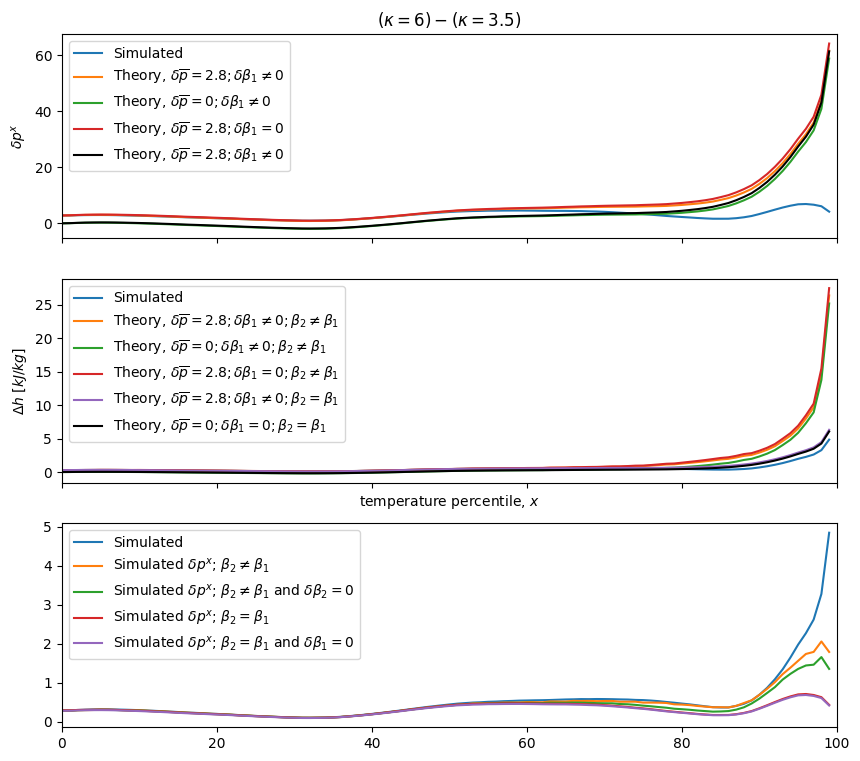

In [640]:
# Equation 23 plot for the percentile
delta_p_x_theory_2 = -(beta1[1]-beta1[0])/beta1[0]**2 * (mse_quant[0] - h_mean[0]) + \
                     (mse_quant[1]-mse_quant[0] - (h_mean[1] - h_mean[0]))/beta1[0] + (p_mean[1] - p_mean[0])
delta_p_x_theory_2_no_p_mean = delta_p_x_theory_2 - (p_mean[1] - p_mean[0])
delta_p_x_theory_4 = (mse_quant[1]-mse_quant[0] - (h_mean[1] - h_mean[0]))/beta1[0] + (p_mean[1] - p_mean[0])
delta_p_x_theory_4_no_p_mean = delta_p_x_theory_4 - (p_mean[1] - p_mean[0])
delta_h_theory_2 = delta_p_x_theory_2 * beta2[1]
delta_h_theory_2_no_p_mean = delta_p_x_theory_2_no_p_mean * beta2[1]
delta_h_theory_3 = delta_p_x_theory_4 * beta2[1]
delta_h_theory_4 = delta_p_x_theory_2 * beta1[1]
delta_h_theory_4_no_p_mean = delta_p_x_theory_4_no_p_mean * beta1[0]

delta_h_theory_7 = (mse_quant_px[1]-mse_quant_px[0]) * beta2[1]
delta_h_theory_8 = (mse_quant_px[1]-mse_quant_px[0]) * beta2[0]
delta_h_theory_9 = (mse_quant_px[1]-mse_quant_px[0]) * beta1[1]
delta_h_theory_10 = (mse_quant_px[1]-mse_quant_px[0]) * beta1[0]

fig, ax = plt.subplots(3,1, figsize=(10, 9), sharex=True)
ax[0].plot(quant_plot, mse_quant_px[1]-mse_quant_px[0], label='Simulated')
ax[0].plot(quant_plot, delta_p_x_theory_2,
        label='Theory, $\delta \overline{p} = ' + f'{np.round(p_mean[1]-p_mean[0],2)}; \delta \\beta_1 \\neq 0$')
ax[0].plot(quant_plot, delta_p_x_theory_2_no_p_mean, label='Theory, $\delta \overline{p} = 0; \delta \\beta_1 \\neq 0$')
ax[0].plot(quant_plot, delta_p_x_theory_4,
        label='Theory, $\delta \overline{p} = ' + f'{np.round(p_mean[1]-p_mean[0],2)}; \delta \\beta_1 = 0$')
ax[0].plot(quant_plot, delta_p_x_theory_4_no_p_mean,
        label='Theory, $\delta \overline{p} = ' + f'{np.round(p_mean[1]-p_mean[0],2)}; \delta \\beta_1 \\neq 0$', color='k')
ax[1].plot(quant_plot, delta_h, label='Simulated')
ax[1].plot(quant_plot, delta_h_theory_2,
           label='Theory, $\delta \overline{p} = ' + f'{np.round(p_mean[1]-p_mean[0],2)}; \delta \\beta_1 \\neq 0; \\beta_2 \\neq \\beta_1$')
ax[1].plot(quant_plot, delta_h_theory_2_no_p_mean,
           label='Theory, $\delta \overline{p} = 0; \delta \\beta_1 \\neq 0; \\beta_2 \\neq \\beta_1$')
ax[1].plot(quant_plot, delta_h_theory_3,
           label='Theory, $\delta \overline{p} = ' + f'{np.round(p_mean[1]-p_mean[0],2)}; \delta \\beta_1 = 0; \\beta_2 \\neq \\beta_1$')
ax[1].plot(quant_plot, delta_h_theory_4,
           label='Theory, $\delta \overline{p} = ' + f'{np.round(p_mean[1]-p_mean[0],2)}; \delta \\beta_1 \\neq 0; \\beta_2 = \\beta_1$')
ax[1].plot(quant_plot, delta_h_theory_4_no_p_mean,
           label='Theory, $\delta \overline{p} = 0; \delta \\beta_1 = 0; \\beta_2 = \\beta_1$',
           color='k')
ax[2].plot(quant_plot, delta_h, label='Simulated')
ax[2].plot(quant_plot, delta_h_theory_7, label='Simulated $\\delta p^x$; $\\beta_2 \\neq \\beta_1$')
ax[2].plot(quant_plot, delta_h_theory_8, label='Simulated $\\delta p^x$; $\\beta_2 \\neq \\beta_1$ and $\delta \\beta_2 = 0$')
ax[2].plot(quant_plot, delta_h_theory_9, label='Simulated $\\delta p^x$; $\\beta_2 = \\beta_1$')
ax[2].plot(quant_plot, delta_h_theory_10, label='Simulated $\\delta p^x$; $\\beta_2 = \\beta_1$ and $\delta \\beta_1 = 0$')
ax[0].set_ylabel('$\delta p^x$')
ax[1].set_xlabel('temperature percentile, $x$')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[1].set_ylabel('$\Delta h$ [$kJ/kg$]')
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
ax[0].set_xlim(0,100);

The first plot above show that none of the theories do a particularly great job at predicting $\delta p^x$. This is because the lowest $p^x$ is around 60, but we are using the gradient at the mean, around 52, which is wrong when we get to these larger $x$ corresponding to larger $p^x$. For the same reason, the most exact theory for $\Delta h$ as shown by the yellow line does really badly at large $x$, where the gradients ($\beta$) used differ more from the actual ones.

However, the simplest theory shown in purple, with $\beta_2 = \beta_1$, $\delta \beta_1 = 0$ and $\delta \bar{p} = 0$ does a good job at predicting $\Delta h$. These three assumptions give the below formula for $\Delta h$:

$\Delta h = \delta h^x - \delta \overline{h}$

Below, we investigate how well we can approximate $\delta h^x - \delta \overline{h}$.

The bottom plot shows that given the exact $\delta p^x$, an accurate value of $\Delta h$ can be obtained if we assume $\delta \beta_2 = 0$ as given by the green line. This implies the purple line in the second plot does only do well due to compensating errors i.e. the purple line in the top plot gives a significant underestimate of $\delta p^x$, the purple line in the bottom plot gives a significant overestimate of $\Delta h$ and when combined to give the purple line in the second plot, it appears to do quite well.

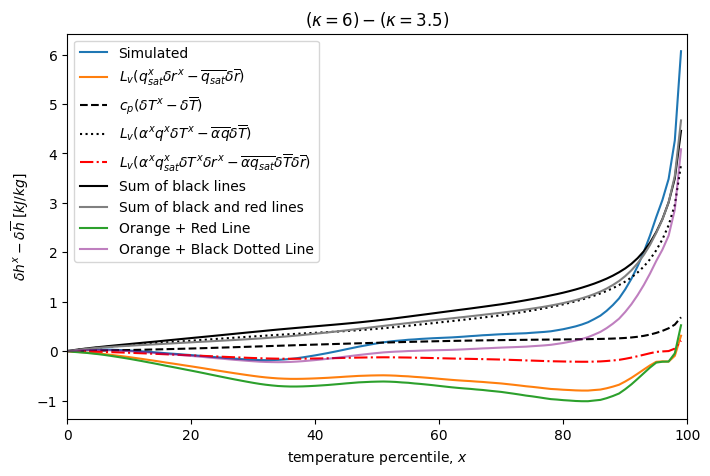

In [641]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(quant_plot, mse_quant[1]-mse_quant[0] - (h_mean[1]-h_mean[0]), label='Simulated')
delta_h_taylor_terms = [L_v/1000 * delta_r_x * q_x_sat,
                        c_p/1000 * (temp_quant[1]-temp_quant[0]),
                        L_v/1000 * alpha * q_x * delta_temp_quant,
                        L_v/1000 * alpha * q_x_sat * delta_temp_quant * delta_r_x]
delta_h_taylor_terms = np.asarray([var-var[0] for var in delta_h_taylor_terms])
ax.plot(quant_plot, delta_h_taylor_terms[0],
        label='$L_v(q_{sat}^x \delta r^x - \overline{q_{sat}} \delta \overline{r})$')
ax.plot(quant_plot, delta_h_taylor_terms[1], label='$c_p (\delta T^x - \delta \overline{T})$', color='k', linestyle='--')
ax.plot(quant_plot, delta_h_taylor_terms[2], color='k', linestyle=':',
        label='$L_v (\\alpha^x q^x \delta T^x - \overline{\\alpha} \overline{q} \delta \overline{T})$')
ax.plot(quant_plot, delta_h_taylor_terms[3], color='r', linestyle='-.',
        label='$L_v (\\alpha^x q_{sat}^x \delta T^x \delta r^x - \overline{\\alpha} \overline{q_{sat}} \delta \overline{T} \delta \overline{r})$')
ax.plot(quant_plot, np.sum(delta_h_taylor_terms[1:3], axis=0), color='k', label='Sum of black lines')
ax.plot(quant_plot, np.sum(delta_h_taylor_terms[1:4], axis=0), color='grey', label='Sum of black and red lines')
ax.plot(quant_plot, delta_h_taylor_terms[0] + delta_h_taylor_terms[3],
        label='Orange + Red Line')
ax.plot(quant_plot, delta_h_taylor_terms[0] + delta_h_taylor_terms[2],
        label='Orange + Black Dotted Line', color='purple', alpha=0.5)
ax.legend()
ax.set_ylabel('$\delta h^x - \delta \overline{h}$ [$kJ/kg$]')
ax.set_xlabel('temperature percentile, $x$')
ax.set_xlim(0,100)
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$');

The yellow line is that used in the paper, but from this plot, it seems using the green line, which also includes non-linear terms would give a significant improvement.

The important thing is that some of the $\delta T$ terms sum to give approximately 0 for all $x$ (solid black or grey lines).

So, our final approximations for $\Delta h$ are:
* $\beta_2 = \beta_1$
* $\delta \beta_1 = 0$
* $\delta \bar{p} = 0$
* $\delta h^x - \delta \overline{h} = L_v(q_{sat}^x \delta r^x + \alpha^x q_{sat}^x \delta T^x \delta r^x - \overline{q_{sat}} \delta \overline{r} - \overline{\alpha} \overline{q_{sat}} \delta \overline{T} \delta \overline{r})$

This is shown by the dotted line below, the dashed line neglects the non-linear terms i.e. it uses the orange line above, and is clearly worse.

For warmer climates, the purple line matches best to the blue line in the above plot. So below, we investigate the predictions for $\delta T^x$ from this equation for $\Delta h$. This results in $q\delta T$ terms being excluded from the $\delta T^x$ equation i.e.
$$ \delta T^x = \frac{c_p + L_v \bar{\alpha} \overline{q_{sat}} \delta \overline{r}}{c_p + L_v \alpha^x q_{sat}^x \delta r^x}\delta \overline{T}$$

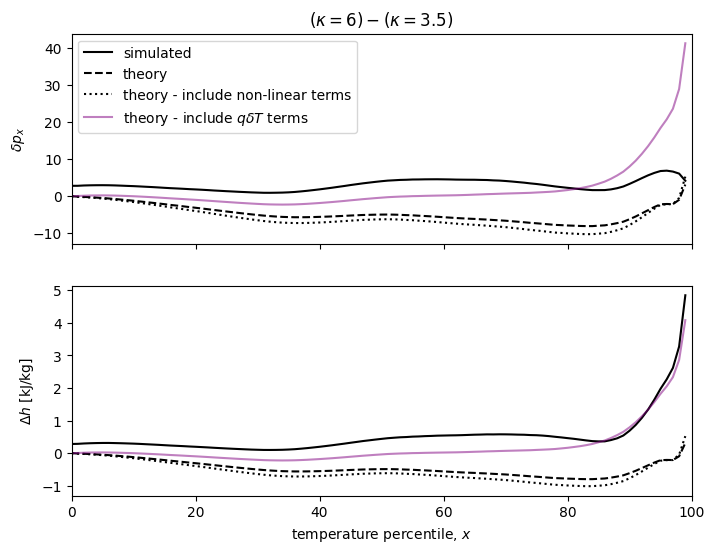

In [642]:
fig_delta_h2 = copy.deepcopy(fig_delta_h)
ax = fig_delta_h2.axes
ax[0].plot(quant_plot, (delta_h_taylor_terms[0] + delta_h_taylor_terms[2])/beta1[0], color='purple', alpha=0.5, label='theory - include $q \delta T$ terms')
ax[1].plot(quant_plot, delta_h_taylor_terms[0] + delta_h_taylor_terms[2], color='purple', alpha=0.5)
ax[0].legend()
fig_delta_h2

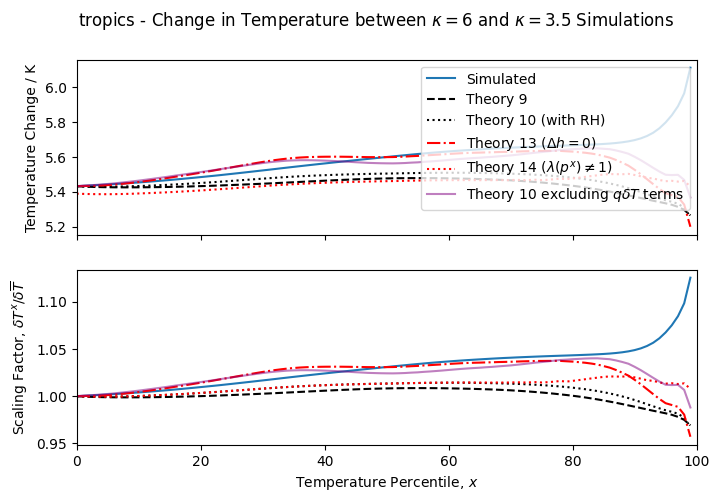

In [643]:
fig_temp2 = copy.deepcopy(fig_temp)
ax = fig_temp2.axes
ax[0].plot(quant_plot, delta_temp_mean * (c_p + L_v * alpha_mean * q_mean_sat * delta_r_mean)/(c_p + L_v * alpha * q_x_sat * delta_r_x),
           color='purple', alpha=0.5, label='Theory 10 excluding $q \delta T$ terms')
ax[1].plot(quant_plot, (c_p + L_v * alpha_mean * q_mean_sat * delta_r_mean)/(c_p + L_v * alpha * q_x_sat * delta_r_x),
           color='purple', alpha=0.5)
ax[0].legend()
fig_temp2